### 0. Import util libraries

In [10]:
import numpy as np
import torch
torch.manual_seed(123)
from scipy import interpolate
import random
from scipy.integrate import solve_ivp

# helmholtz gp imports
import helmholtz_gp.helmholtz_regression_pytorch as hrp
import helmholtz_gp.plot_helper_arxiv as plot_helm
from helmholtz_gp.parameters import TwoKernelGPParams
from helmholtz_gp.optimization_loop import basic_optimization_loop

# d-hnn imports
import dissipative_hnns
from dissipative_hnns.models import MLP, DHNN, HNN
from dissipative_hnns.train import train, get_args

# set plotting params for the notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [20, 10]
mpl.rcParams['figure.dpi'] = 300
np.set_printoptions(precision=5)
from matplotlib import cm
plt.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Times"],
            "font.size": 12,
        }
    )

### 1. Import the data

In [11]:
X_grid = np.genfromtxt('../data/Xgrid_gladsparse.csv', delimiter=',')
Y_grid = np.genfromtxt('../data/Ygrid_gladsparse.csv', delimiter=',')
XY_train = torch.from_numpy(np.genfromtxt('../data/XY_train_gladsparse.csv', delimiter=','))
XY_test = torch.from_numpy(np.genfromtxt('../data/XY_test_gladsparse.csv', delimiter=','))
UV_train = torch.from_numpy(np.genfromtxt('../data/UV_train_gladsparse.csv', delimiter=','))

### 2. Visualize the data

We first visualize the imported data. Here we just have the velocity field. 

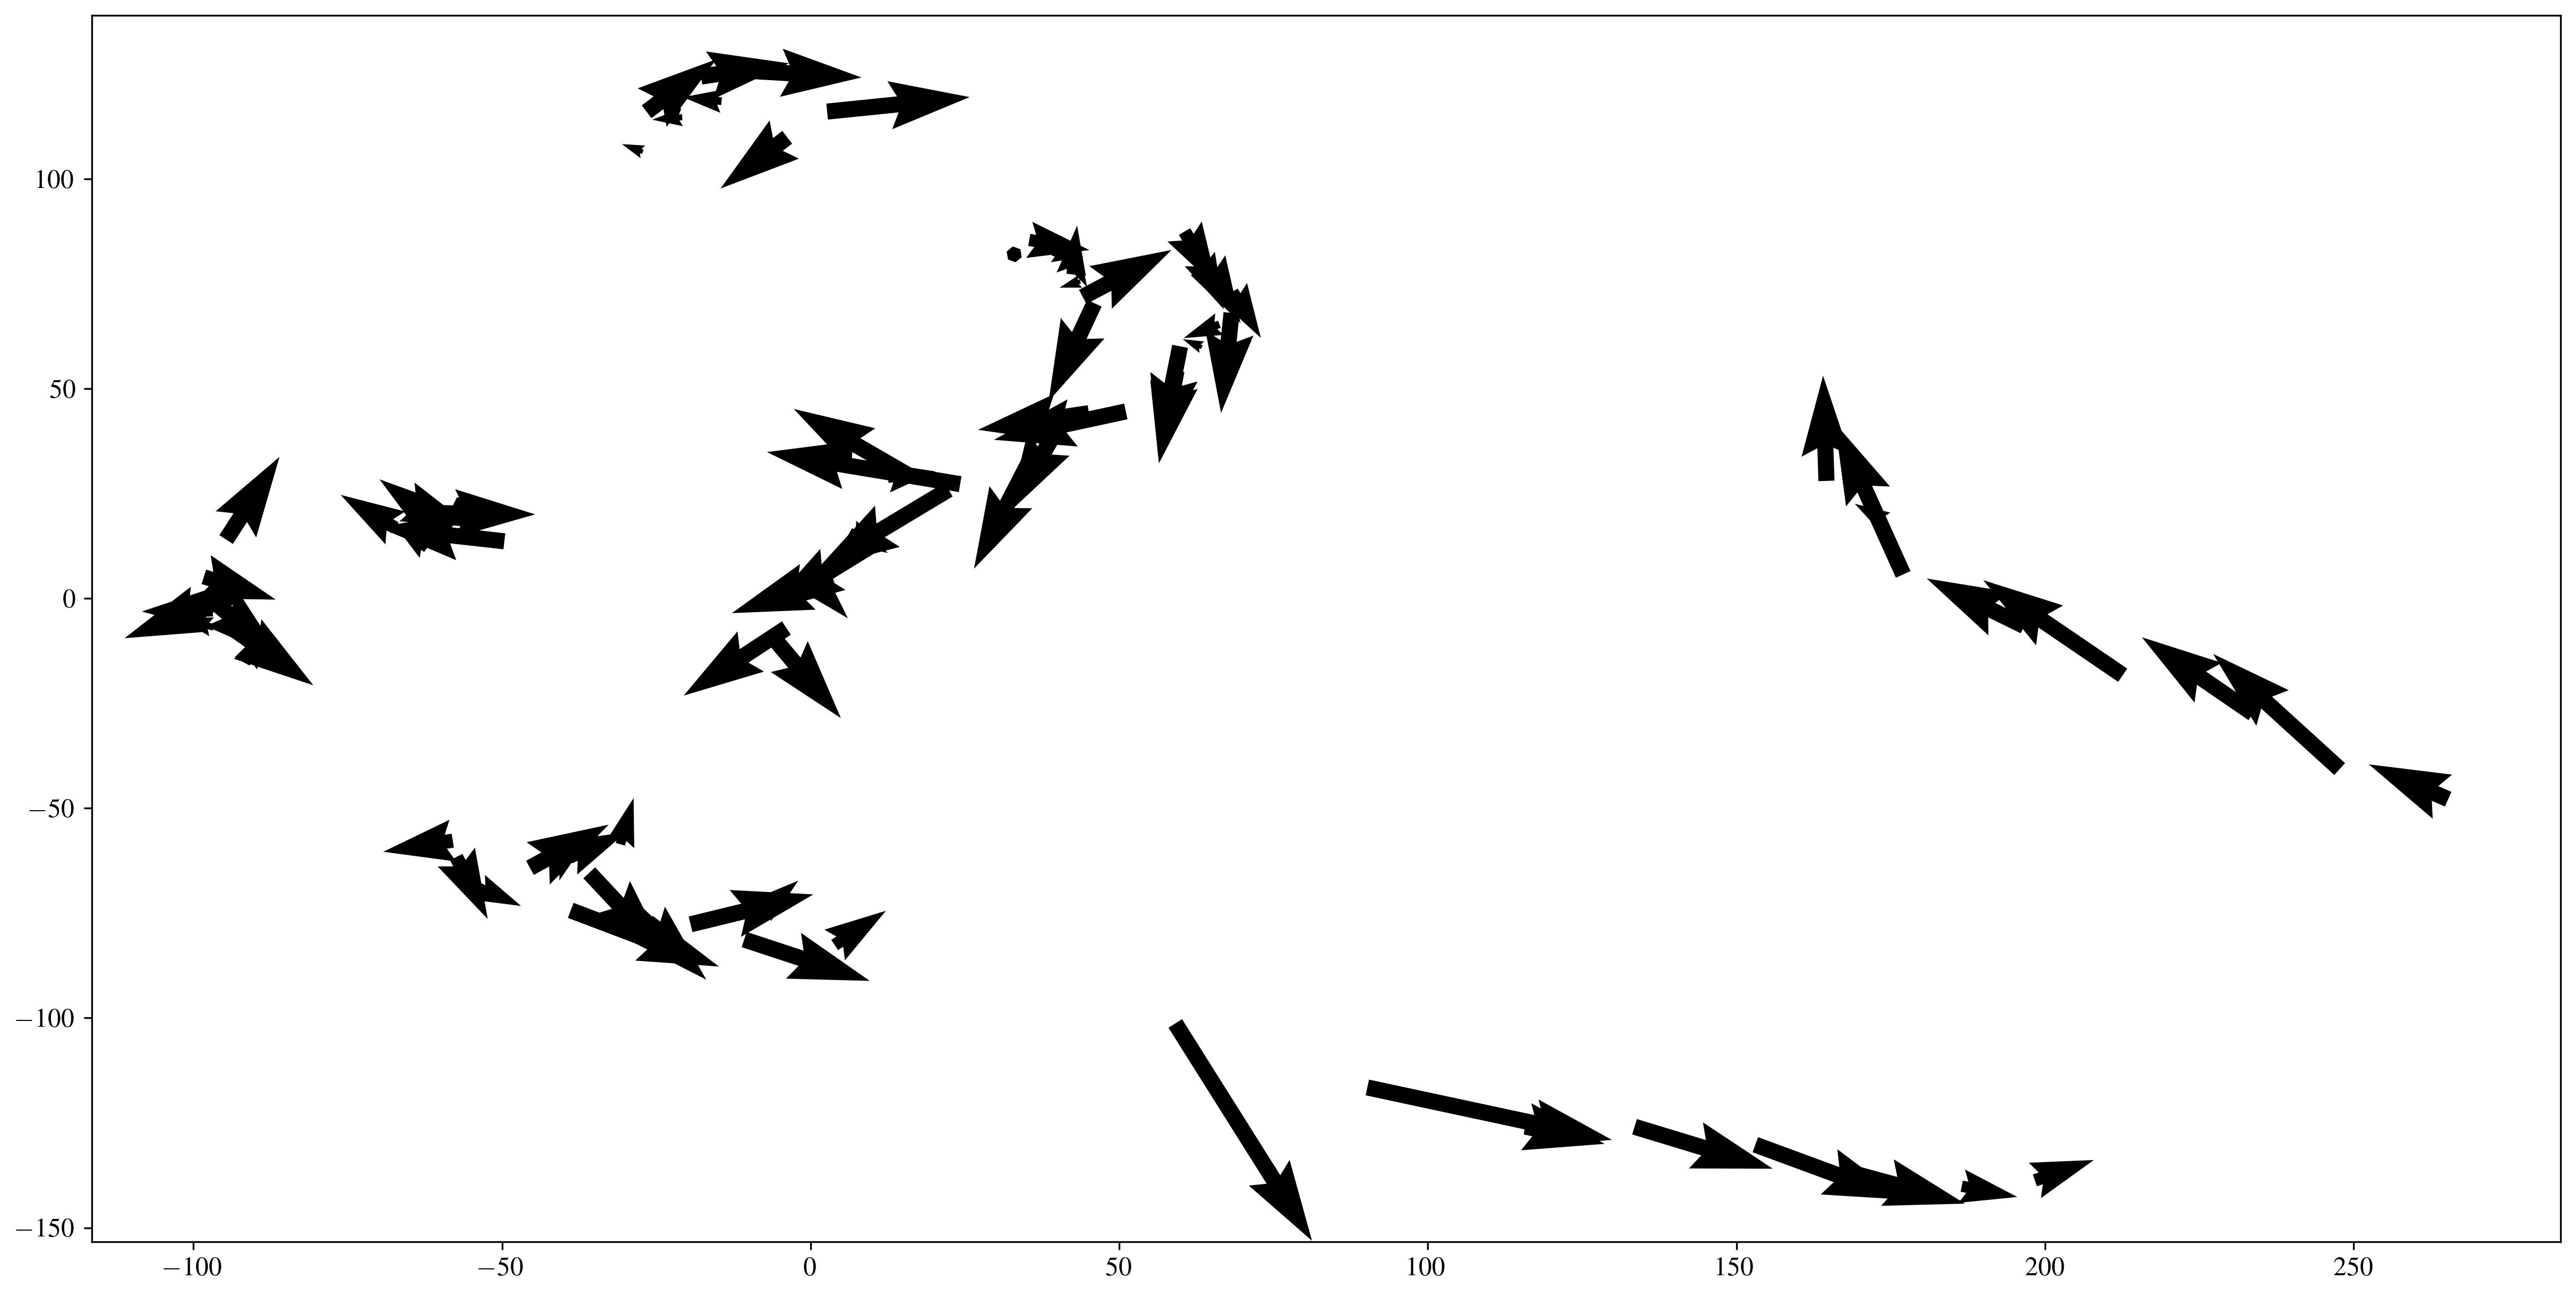

In [12]:
plt.quiver(XY_train[:,0], XY_train[:,1], UV_train[:,0], UV_train[:,1], scale=8)

### 3. Fit the Helmholtz GP 

We first fit the Helmholtz GP. The parameters are optimized on the log-scale, as follows. The loss function is the negative log-likelihood of the training points. 

Optimizer for GP:

In [13]:
log_ls_Phi = torch.tensor(2.5, requires_grad=True) 
log_sigma_Phi = torch.tensor(-2., requires_grad=True)
log_ls_A = torch.tensor(2., requires_grad=True)
log_sigma_A = torch.tensor(1.1, requires_grad=True) 
log_obs_noise_helm = torch.tensor(-2., requires_grad=True)

params_helm = [log_ls_Phi,log_sigma_Phi,log_ls_A,log_sigma_A,log_obs_noise_helm]
params_helm = TwoKernelGPParams(*params_helm)

def loss_helm(params_helm):
    return -hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, kind = "helmholtz", params=params_helm)[2][0,0]

In [14]:
basic_optimization_loop(loss_helm, params_helm)

At step 0, loss: -137.8290873688506
At step 100, loss: -177.19504319925142
At step 200, loss: -180.40656435234962
At step 300, loss: -185.1339323924927
At step 400, loss: -188.82026597089714
At step 500, loss: -190.5784305705631
At step 600, loss: -193.96334381779235
At step 700, loss: -195.70269829954472
At step 800, loss: -195.93738927329073
At step 900, loss: -195.97436192358066


We can show the optimal parameters:

In [15]:
best_params_helm = params_helm.get_params()
best_params_helm

[tensor(45.8112, grad_fn=<ExpBackward0>),
 tensor(0.0360, grad_fn=<ExpBackward0>),
 tensor(80.2998, grad_fn=<ExpBackward0>),
 tensor(13.5849, grad_fn=<ExpBackward0>),
 tensor(0.1716, grad_fn=<ExpBackward0>)]

We visualize the predicted mean and covariance:

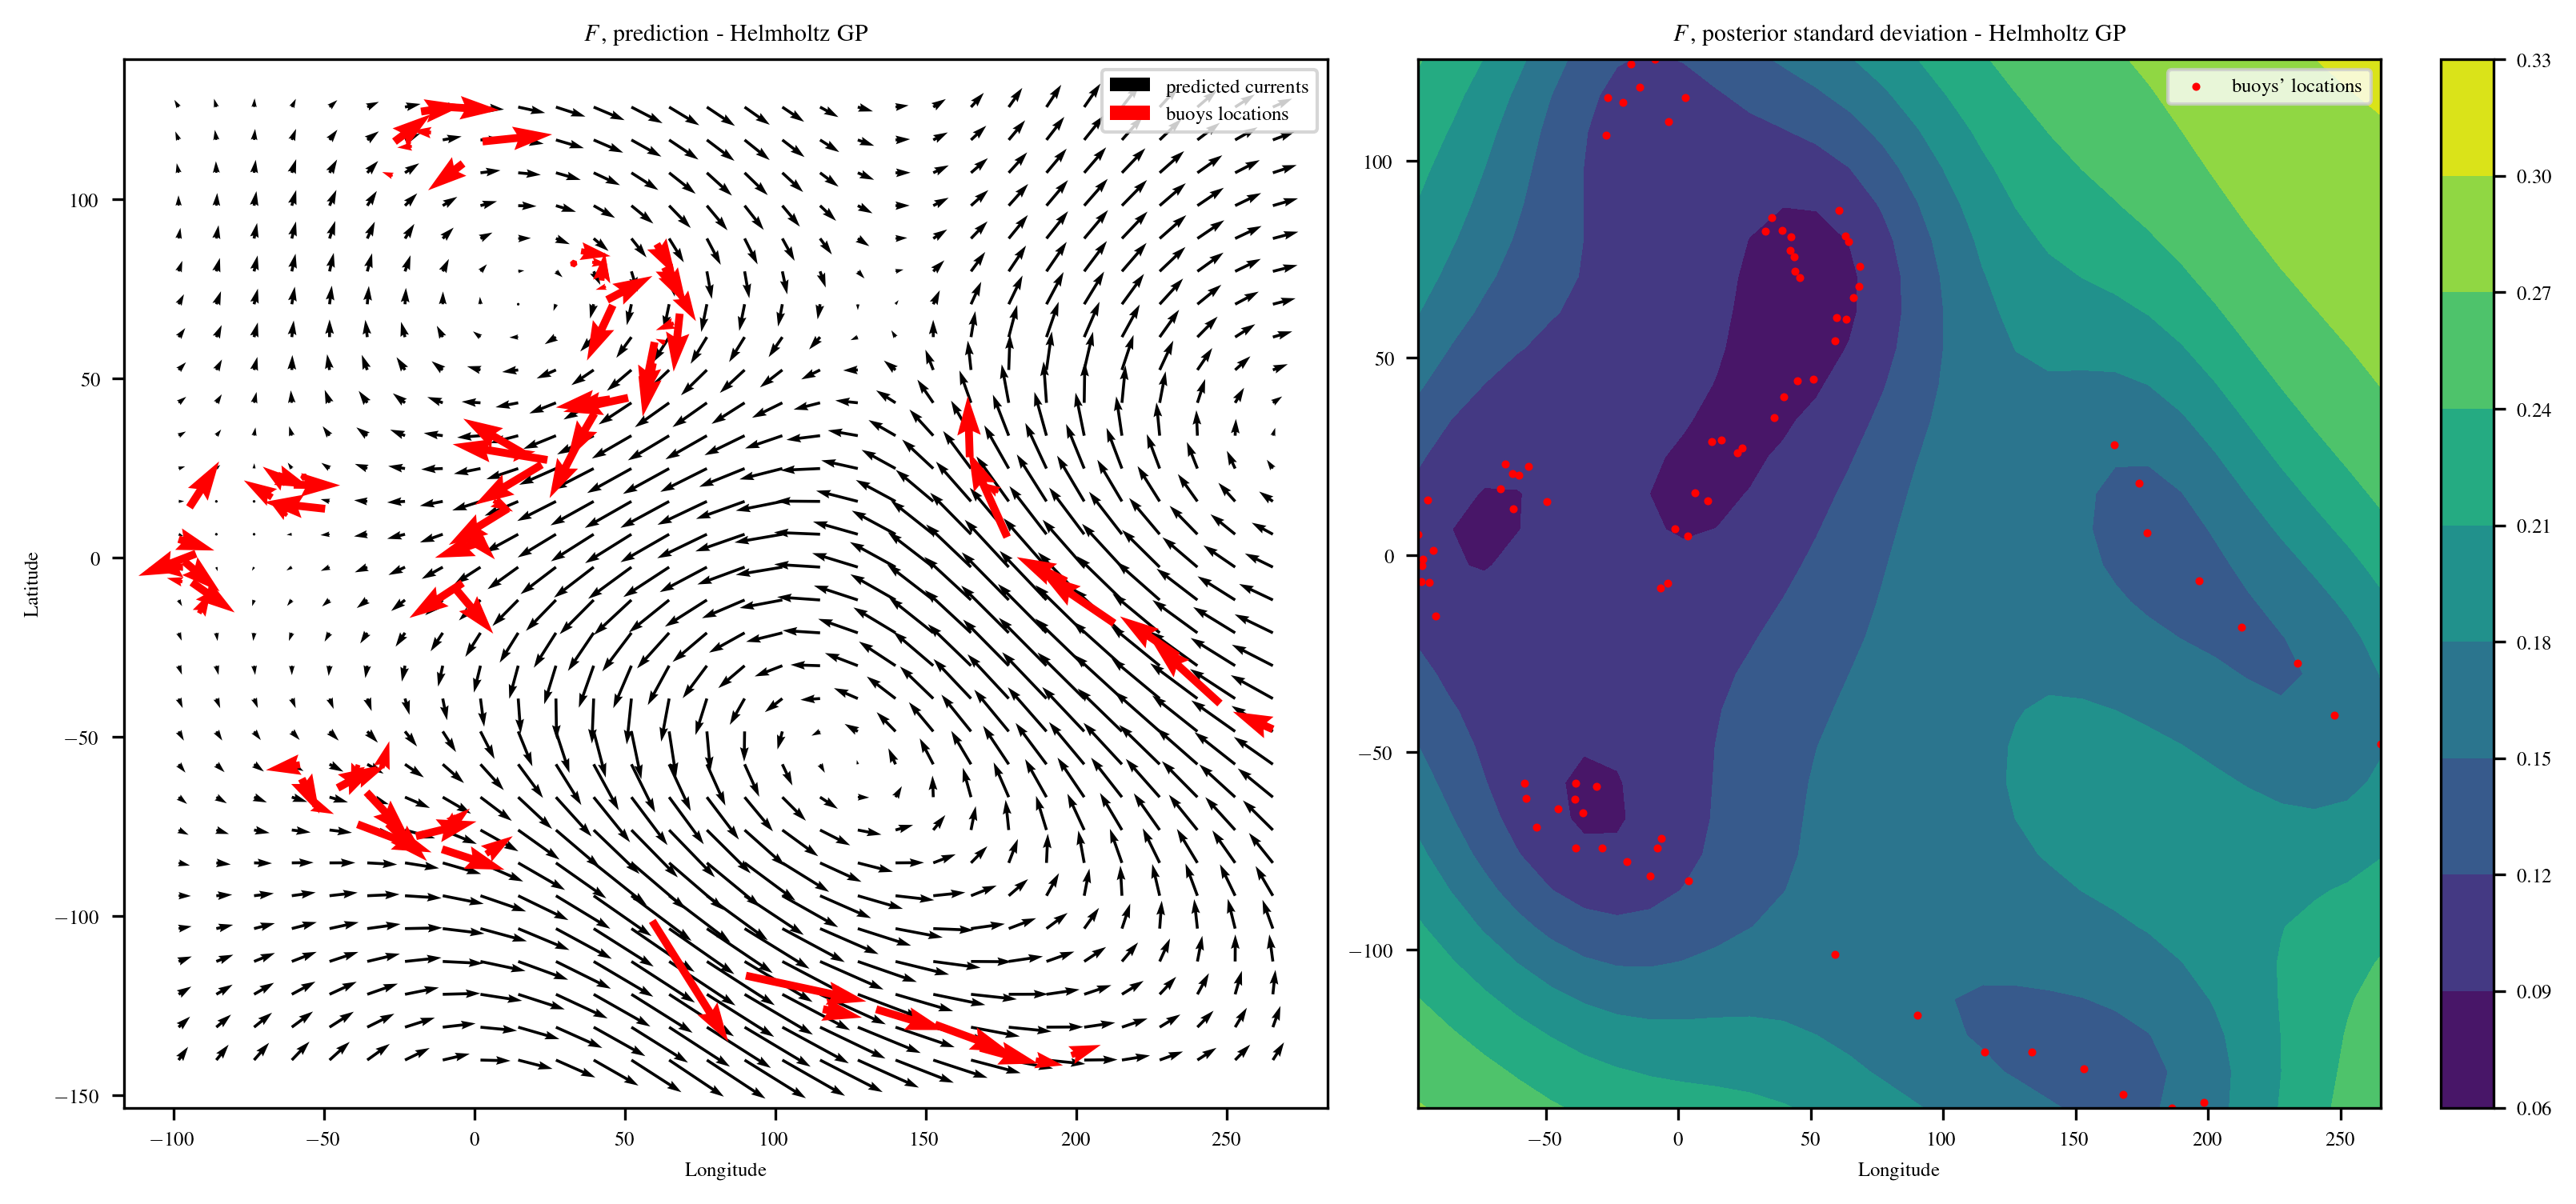

In [40]:
opt_post_mean_helm, opt_post_cov_helm, opt_ll_helm = hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, "helmholtz", params_helm)

plot_helm.plot_results_grid(X_grid, Y_grid, XY_train, UV_train, opt_post_mean_helm, opt_post_cov_helm, levels="", scale=0.02, method="Helmholtz GP")


### 4. Fit velocity GP regression

We then fit the velocity GP, in a similar way.

In [17]:
log_ls_u = torch.tensor(1., requires_grad=True) 
log_sigma_u = torch.tensor(0., requires_grad=True)
log_ls_v = torch.tensor(1., requires_grad=True)
log_sigma_v = torch.tensor(0., requires_grad=True) 
log_obs_noise_uv = torch.tensor(-2., requires_grad=True)

params_uv = [log_ls_u,log_sigma_u,log_ls_v,log_sigma_v,log_obs_noise_uv]
params_uv = TwoKernelGPParams(*params_uv)

def loss_uv(params_uv):
    return -hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, kind = "standard", params=params_uv)[2][0,0]

In [18]:
basic_optimization_loop(loss_uv, params_uv)

At step 0, loss: -0.8142511533351957
At step 100, loss: -138.7946022883407
At step 200, loss: -177.99431185369855
At step 300, loss: -187.3888471703913
At step 400, loss: -189.13151957400572
At step 500, loss: -190.07520570310902
At step 600, loss: -190.79323147535675
At step 700, loss: -190.9457394818669
At step 800, loss: -190.97813967432194


In [19]:
best_params_uv = params_uv.get_params()
best_params_uv

[tensor(72.6984, grad_fn=<ExpBackward0>),
 tensor(0.2631, grad_fn=<ExpBackward0>),
 tensor(2.7183, grad_fn=<ExpBackward0>),
 tensor(0.1348, grad_fn=<ExpBackward0>),
 tensor(0.1739, grad_fn=<ExpBackward0>)]

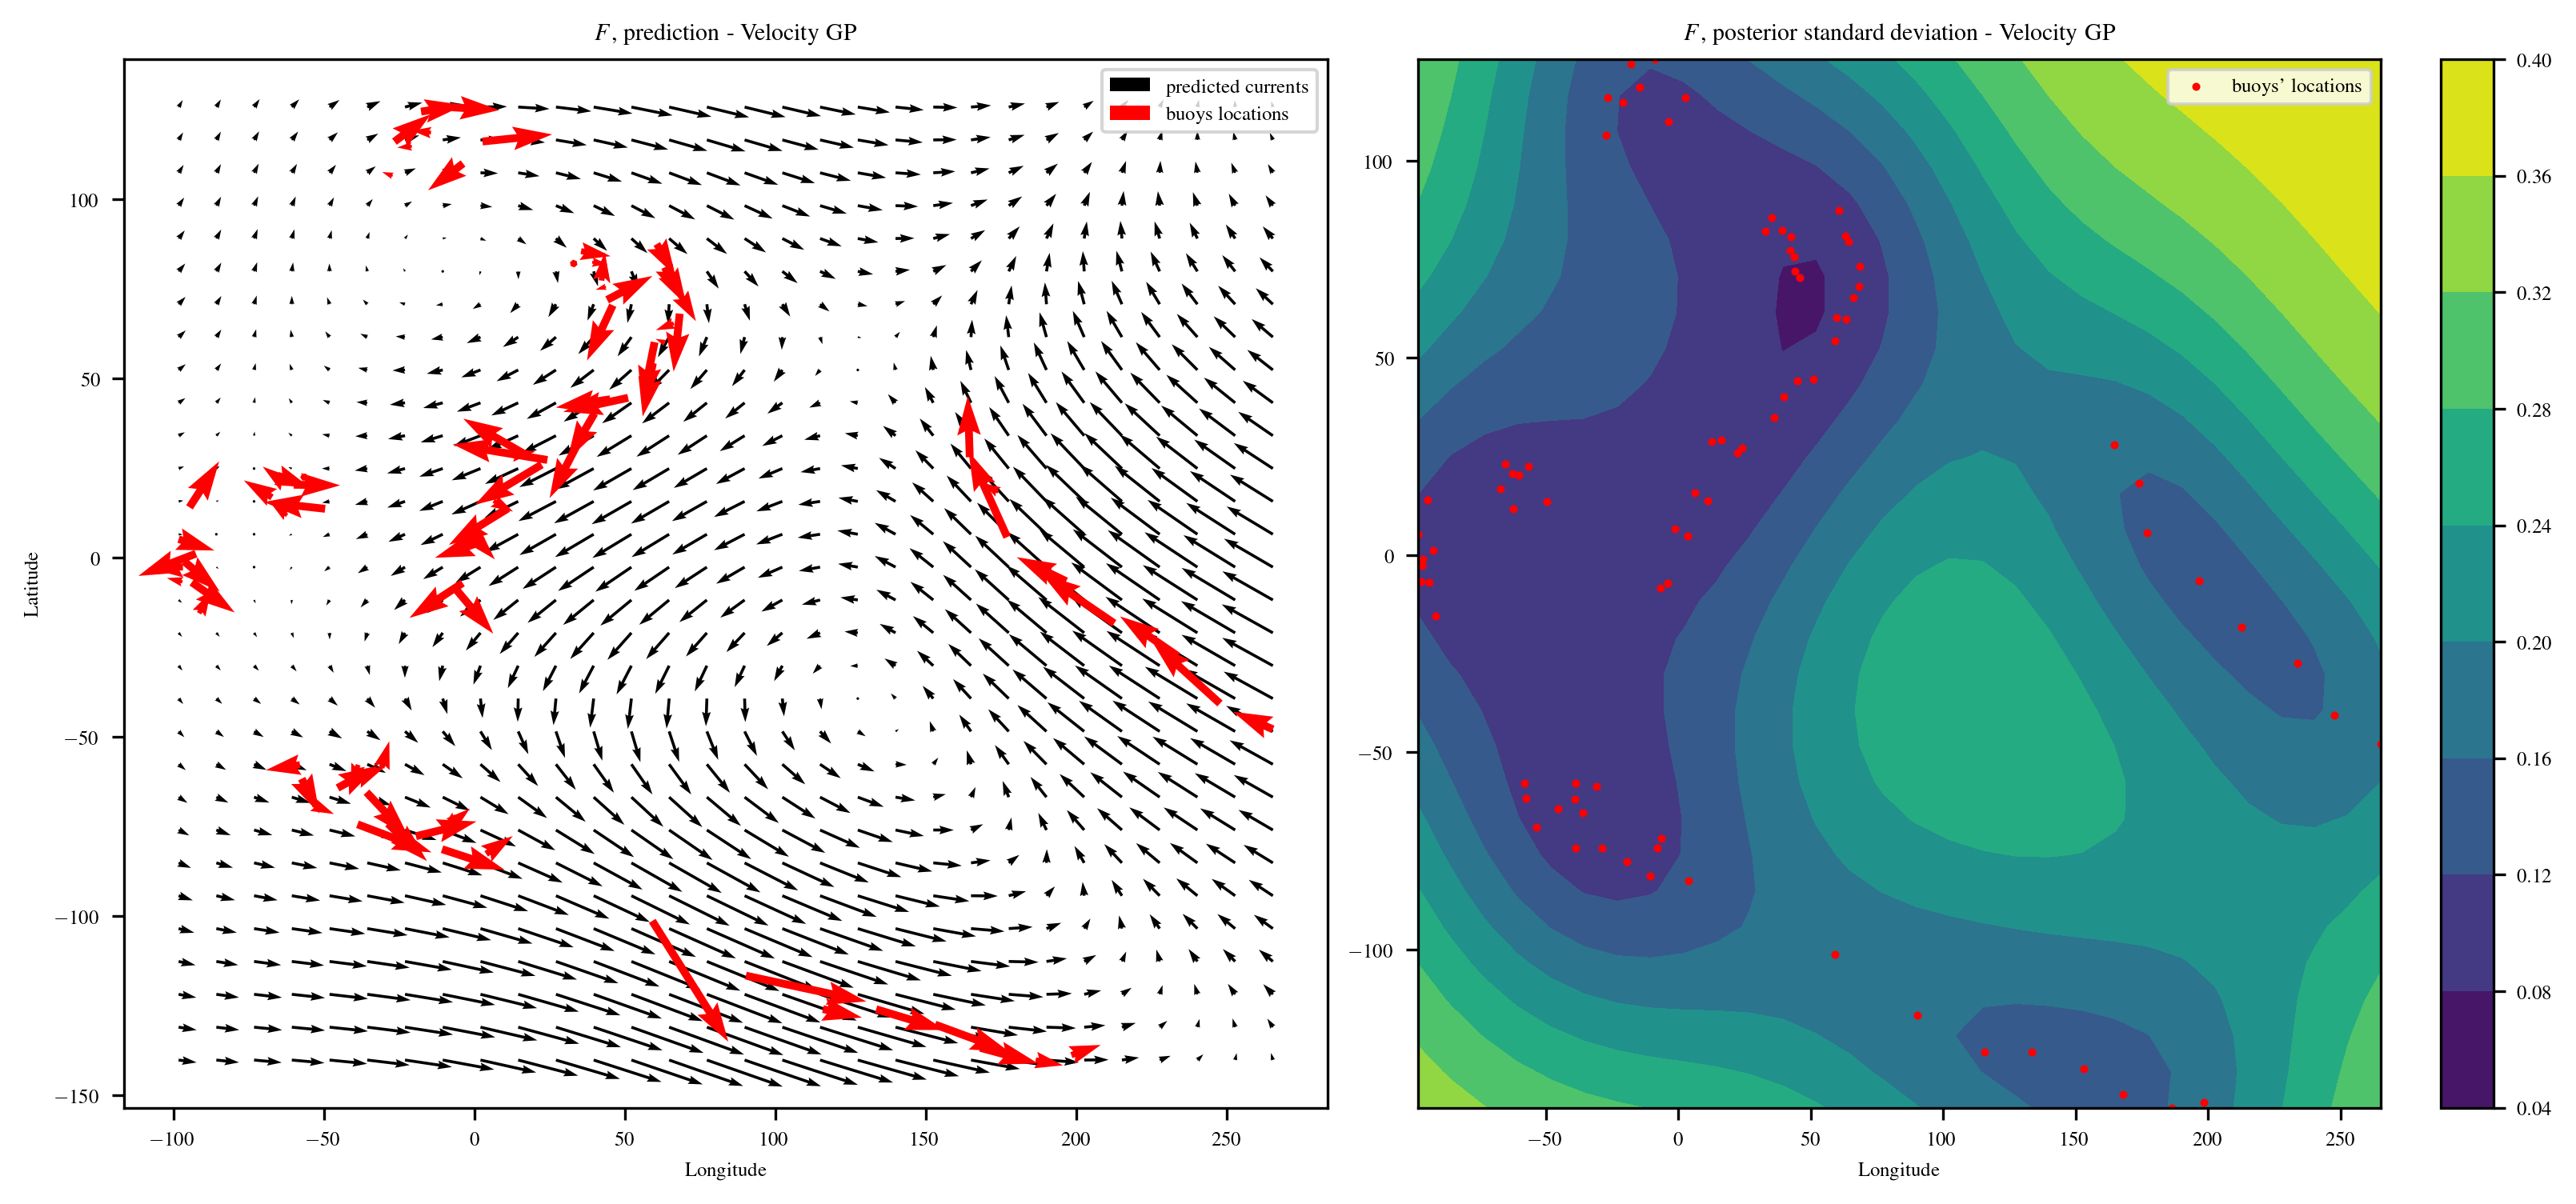

In [41]:
opt_post_mean_uv, opt_post_cov_uv, opt_ll_uv = hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, "standard", params_uv)

plot_helm.plot_results_grid(X_grid, Y_grid, XY_train, UV_train, opt_post_mean_uv, opt_post_cov_uv, levels=False, scale=0.02, method="Velocity GP")


### 5. Visually compare velocity field predictions

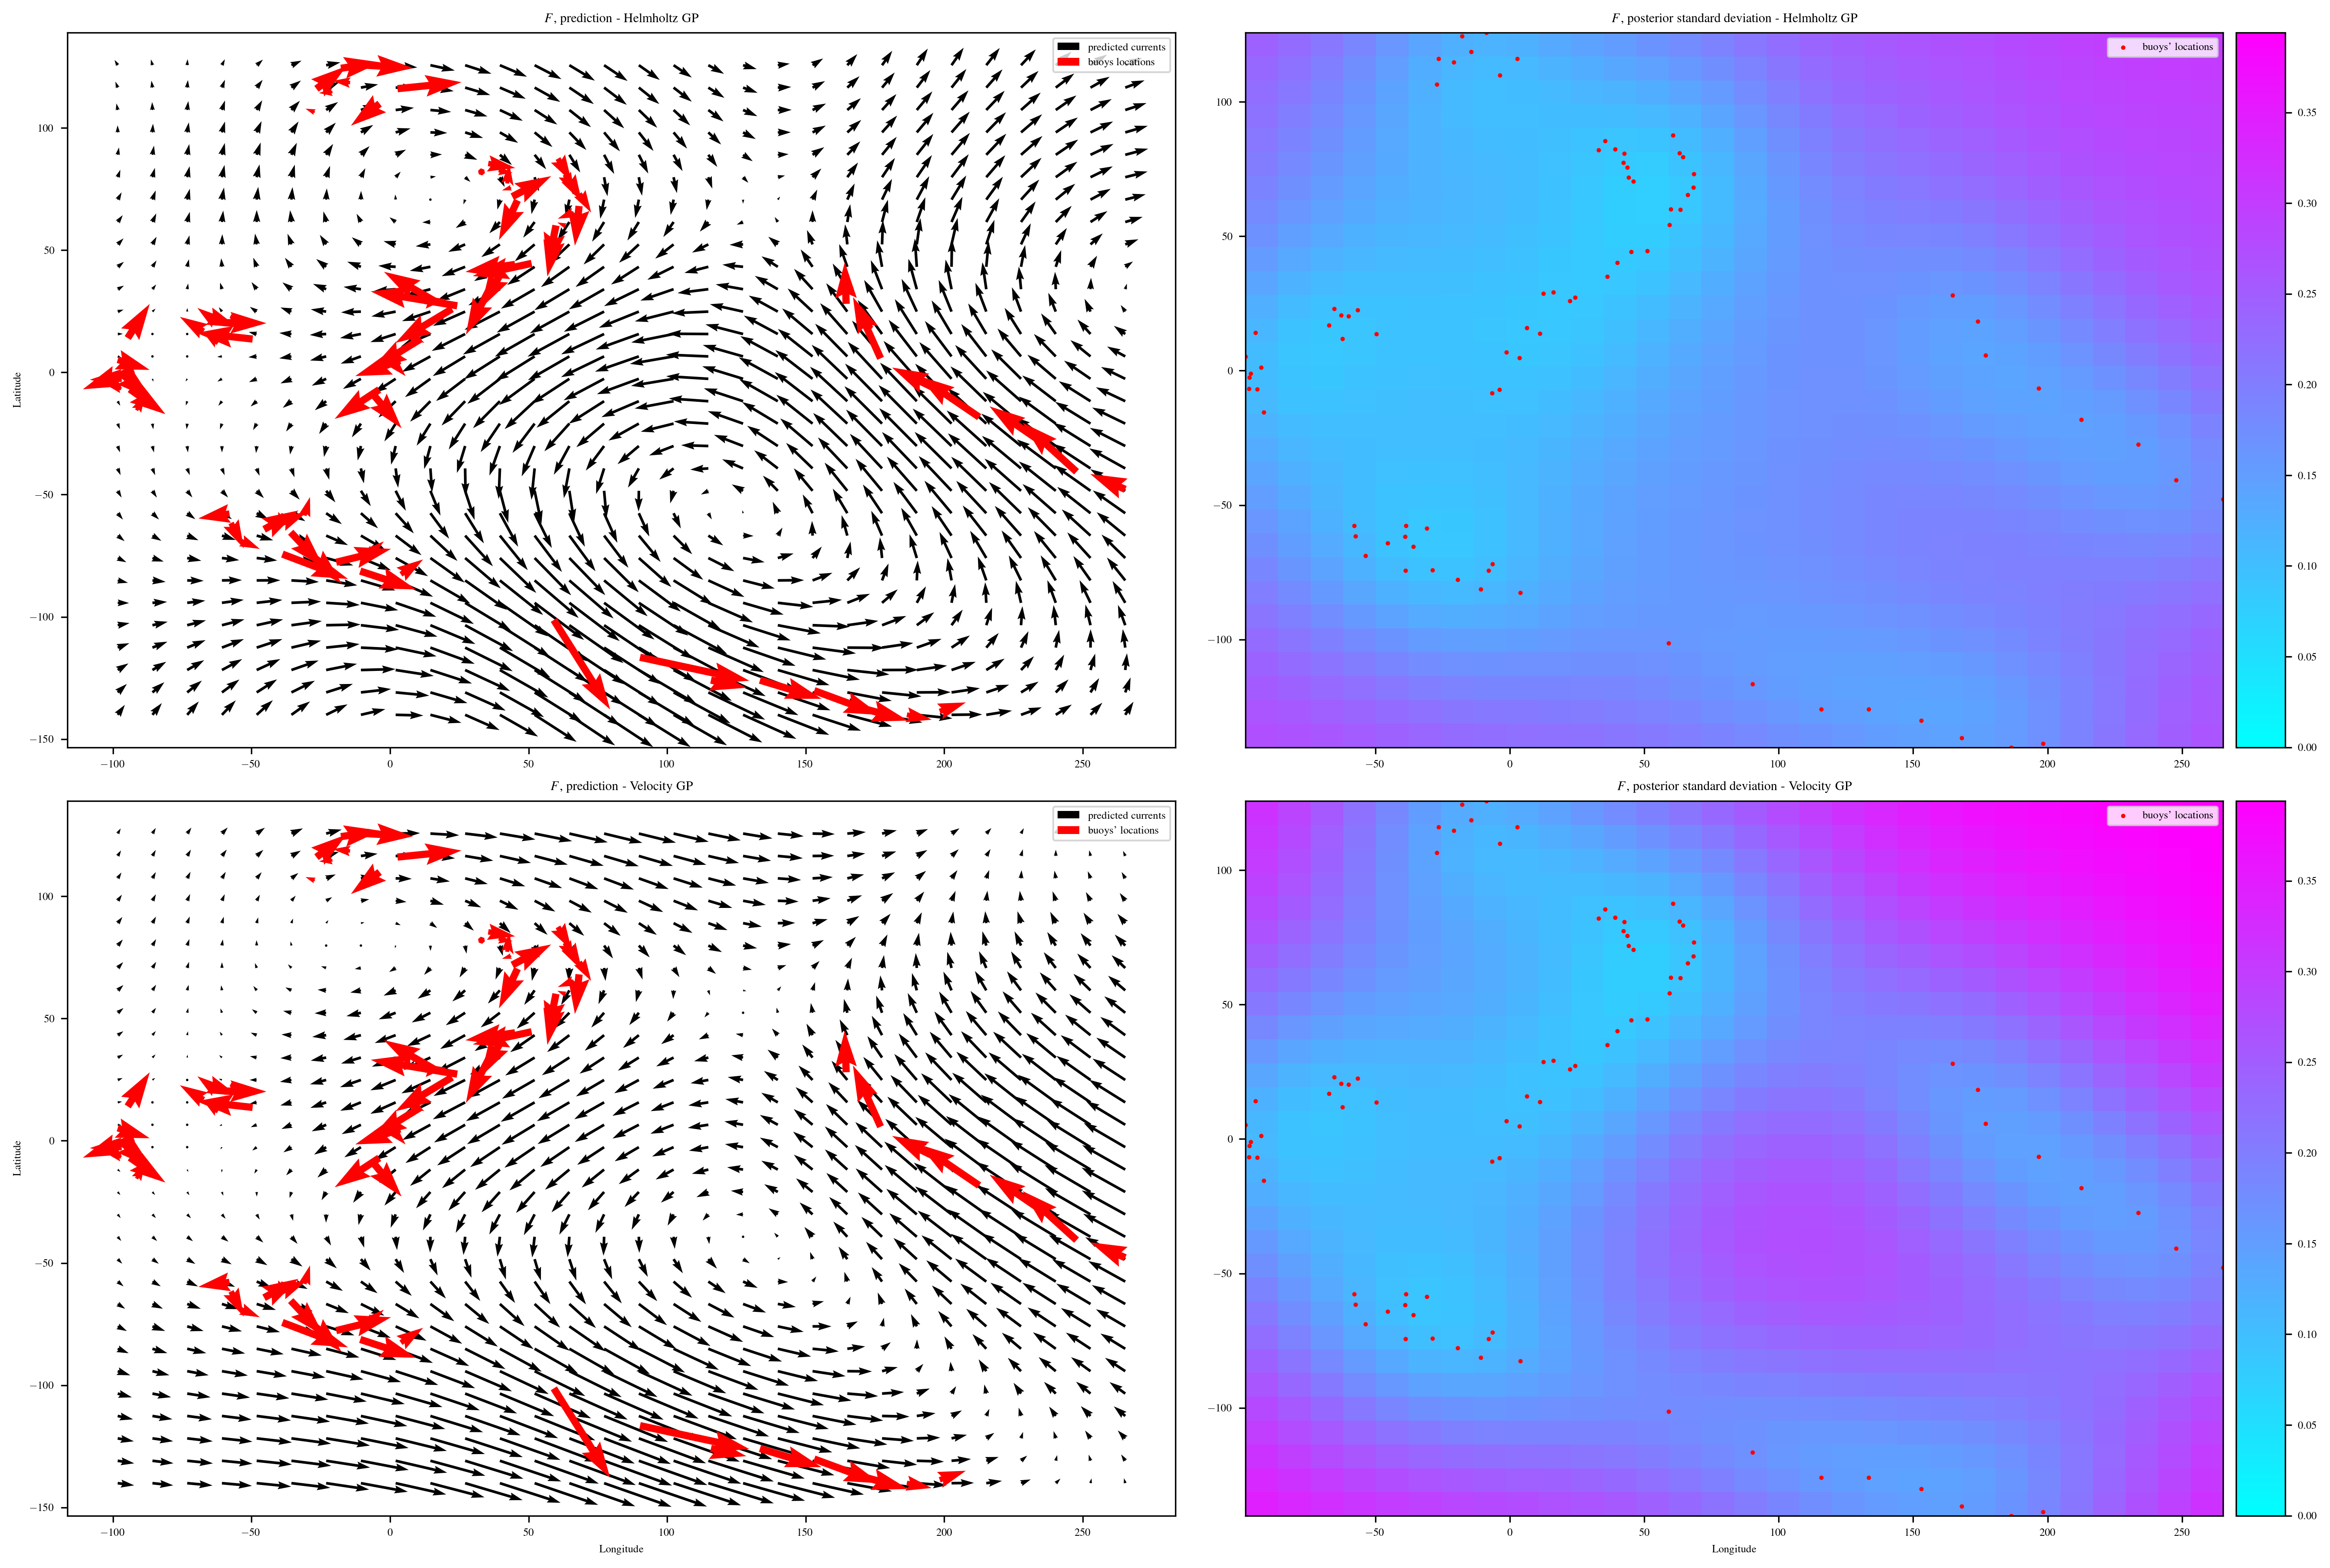

In [39]:
plot_helm.plot_results_comparison_realdata(X_grid, Y_grid, XY_train, UV_train, 
                                            opt_post_mean_helm, opt_post_cov_helm,
                                            opt_post_mean_uv, opt_post_cov_uv,
                                            scale=0.02, cmap='cool')
                                        

### 6. Posterior divergence analysis

We compute the posterior divergence for both methods, and we visually compare the predictions, uncertainty, and z-values.

In [22]:
div_mean_helm, div_var_helm = hrp.posterior_divergence_forloop_diffphi(XY_test, XY_train, UV_train, params_helm)
div_mean_std, div_var_std = hrp.posterior_divergence_forloop(XY_test, XY_train, UV_train, "standard", params_uv)

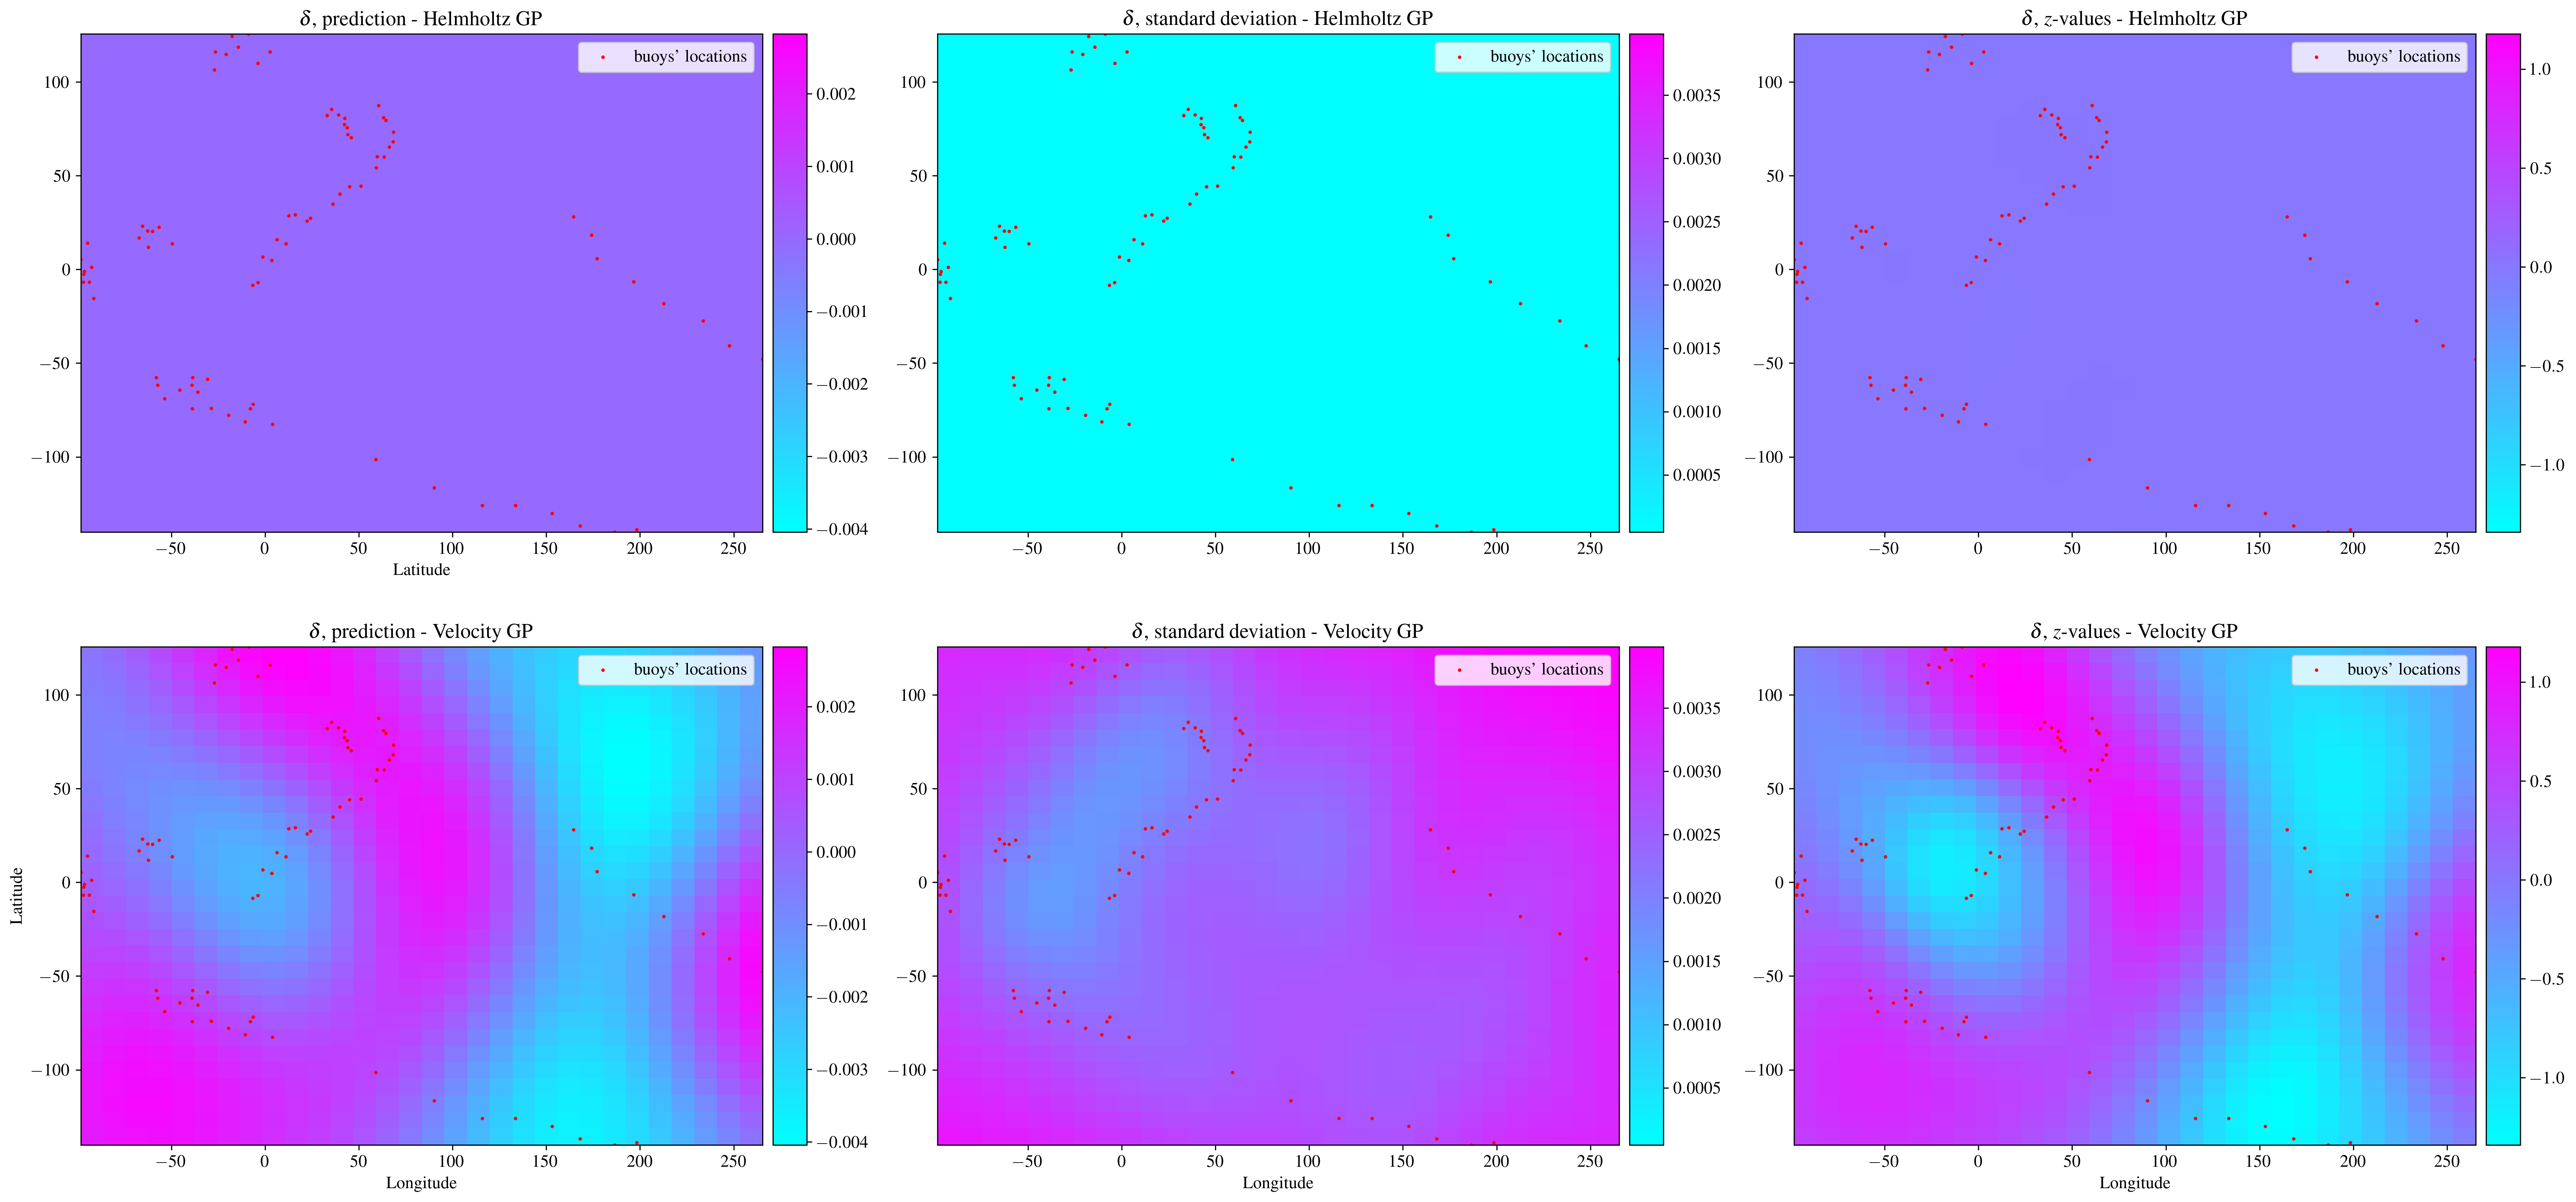

In [23]:
plot_helm.plot_scalarfield_comparison_realdata(X_grid, Y_grid, XY_train,
                                                div_mean_helm, div_var_helm,
                                                div_mean_std, div_var_std, 
                                                component="$\delta$", cmap='cool')

### 7. Compute posterior vorticity

Similarly we compute the vorticity and plot the results.

In [24]:
vort_mean_helm, vort_var_helm = hrp.posterior_vorticity_forloop_diffpsi(XY_test, XY_train, UV_train, params_helm)
vort_mean_std, vort_var_std = hrp.posterior_vorticity_forloop(XY_test, XY_train, UV_train, "standard", params_uv)

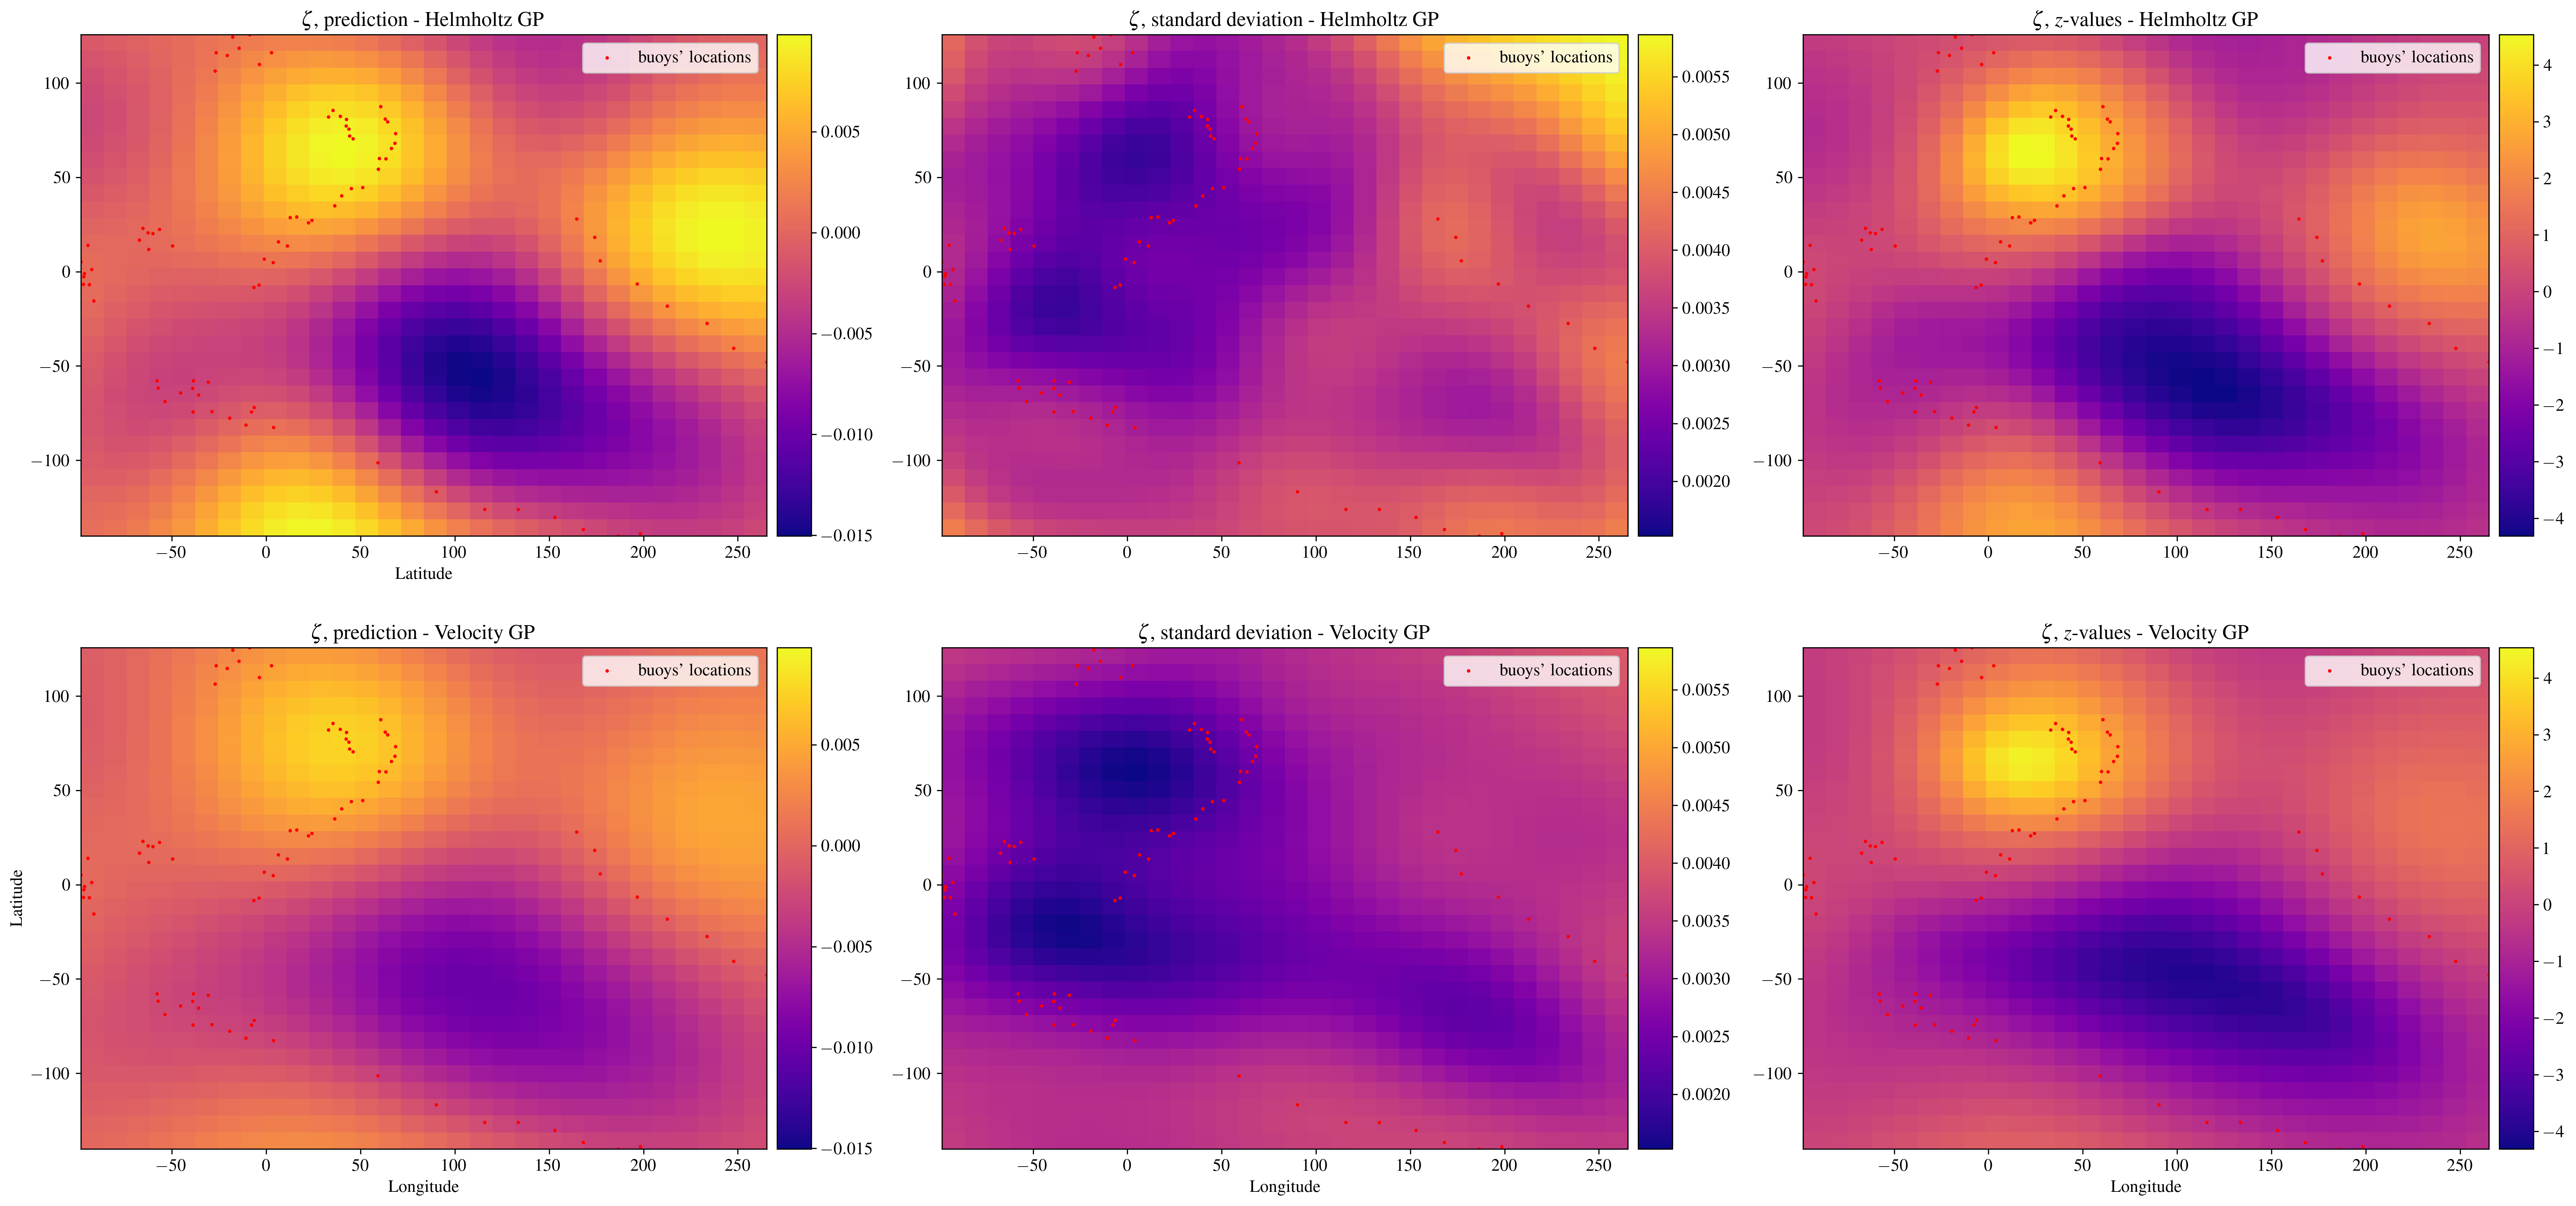

In [25]:
plot_helm.plot_scalarfield_comparison_realdata(X_grid, Y_grid, XY_train,
                                                vort_mean_helm, vort_var_helm,
                                                vort_mean_std, vort_var_std, 
                                                component="$\zeta$", cmap='plasma')

### 8. Get D-HNN predictions

Next, we can get the same set of results with the dissipative Hamiltonian neural network (D-HNN) approach

In [26]:
data = {'x':XY_train,
       'x_test':XY_test,
       't':np.reshape(np.ones(XY_train.shape[0]).T, [-1,1]),
       't_test':np.reshape(np.ones(XY_test.shape[0]).T, [-1,1]),
       'dx':UV_train, 
       'dx_test': np.reshape(np.ones(XY_test.shape[0]).T, [-1,1])
       }

In [27]:
args = get_args()
args.learning_rate = 3e-5
args.total_steps = 50000
args.eval_every = args.print_every = 1000

args.input_dim = 3
args.device = 'cpu'
[f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
dhnn_model = DHNN(args.input_dim, args.hidden_dim)
dhnn_results = train(dhnn_model, args, data)  # training the model

/Users/renb/Desktop/helmholtz_torch_local/dissipative_hnns/train.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(v_batch, requires_grad=True,  dtype=torch.float32, device=args.device)


step 0, dt 0.007, train_loss 5.59e-02, test_loss 1.00e+00
step 1000, dt 5.036, train_loss 8.45e-03, test_loss 1.01e+00
step 2000, dt 4.874, train_loss 3.65e-03, test_loss 1.03e+00
step 3000, dt 4.547, train_loss 1.95e-03, test_loss 1.05e+00
step 4000, dt 4.478, train_loss 1.23e-03, test_loss 1.06e+00
step 5000, dt 4.998, train_loss 1.03e-03, test_loss 1.07e+00
step 6000, dt 4.588, train_loss 7.42e-04, test_loss 1.08e+00
step 7000, dt 4.417, train_loss 4.19e-04, test_loss 1.09e+00
step 8000, dt 4.844, train_loss 5.95e-04, test_loss 1.11e+00
step 9000, dt 5.419, train_loss 2.78e-06, test_loss 1.12e+00
step 10000, dt 5.443, train_loss 6.51e-06, test_loss 1.12e+00
step 11000, dt 4.998, train_loss 4.52e-07, test_loss 1.13e+00
step 12000, dt 4.866, train_loss 3.51e-07, test_loss 1.13e+00
step 13000, dt 4.245, train_loss 7.08e-07, test_loss 1.13e+00
step 14000, dt 5.059, train_loss 4.36e-06, test_loss 1.13e+00
step 15000, dt 4.927, train_loss 2.29e-05, test_loss 1.13e+00
step 16000, dt 5.011,

In [28]:
##Visualize results
[x, x_test, t, t_test] = [torch.tensor(data[v], requires_grad=True,  dtype=torch.float32)
               for v in ['x', 'x_test','t', 't_test']]

#compute predictions at test points
y_hat_irr_test, y_hat_rot_test = dhnn_model(x_test, t=t_test, as_separate=True)
y_hat_test = y_hat_rot_test + y_hat_irr_test

#divergence at test point
divergence_x = torch.autograd.grad(y_hat_irr_test[:,0].sum(), x_test, create_graph=True)[0][:,0]
divergence_y = torch.autograd.grad(y_hat_irr_test[:,1].sum(), x_test, create_graph=True)[0][:,1]
divergence_dhnn = divergence_x + divergence_y

#vorticity at test point
vorticity_x = torch.autograd.grad(y_hat_rot_test[:,0].sum(), x_test, create_graph=True)[0][:,1]
vorticity_y = torch.autograd.grad(y_hat_rot_test[:,1].sum(), x_test, create_graph=True)[0][:,0]
vorticity_dhnn = vorticity_x - vorticity_y

/var/folders/xd/gc1qb67x67gbhkz1mmb7vbg40000gn/T/ipykernel_40709/4211146855.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [x, x_test, t, t_test] = [torch.tensor(data[v], requires_grad=True,  dtype=torch.float32)


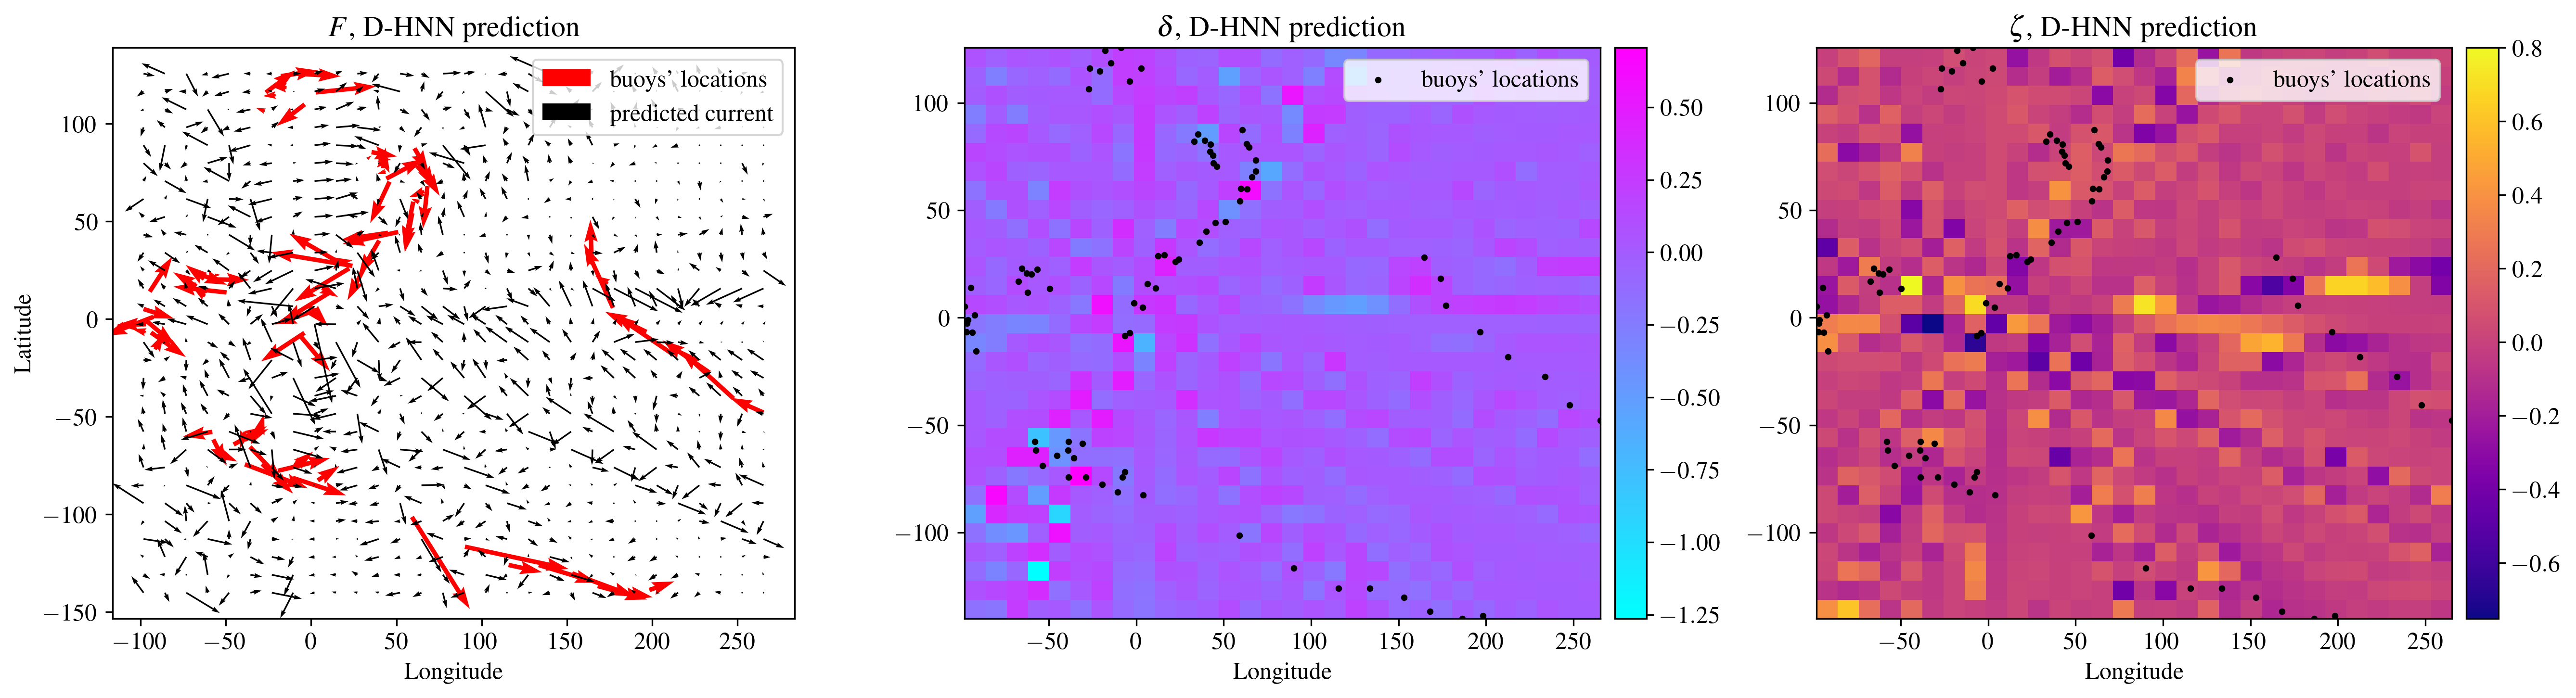

In [29]:
plot_helm.visualize_dhnn_results(X_grid, Y_grid, XY_train, UV_train, XY_test, y_hat_test, vorticity_dhnn, divergence_dhnn, cmap_div='cool', cmap_vort='plasma')

### 9. Plot for the main paper: predicted velocity field & divergence

In [30]:
plt.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Times"],
            "font.size": 6,
        }
    )

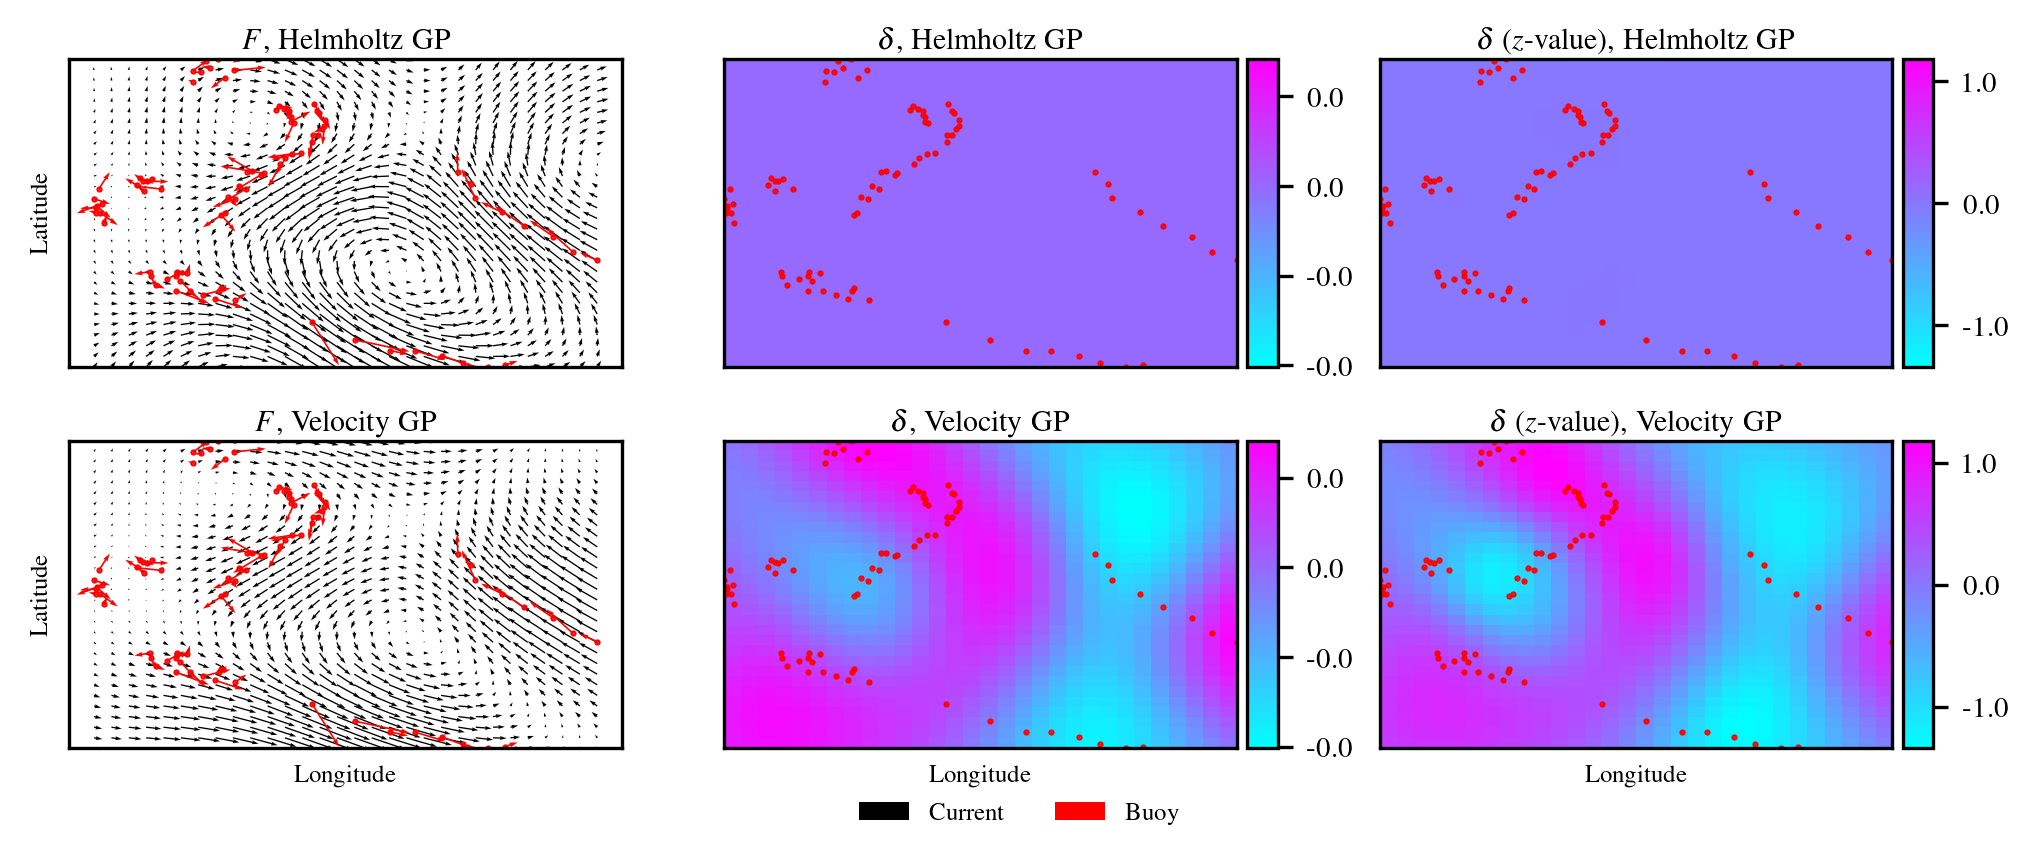

In [38]:
plot_helm.plot_results_paper_realdata(X_grid, Y_grid, XY_train, UV_train,
                                    opt_post_mean_helm, opt_post_cov_helm, 
                                    opt_post_mean_uv, opt_post_cov_uv,
                                    div_mean_helm, div_var_helm, 
                                    div_mean_std, div_var_std, cmap='cool', scale=0.02)

### 10. Plots for the appendix

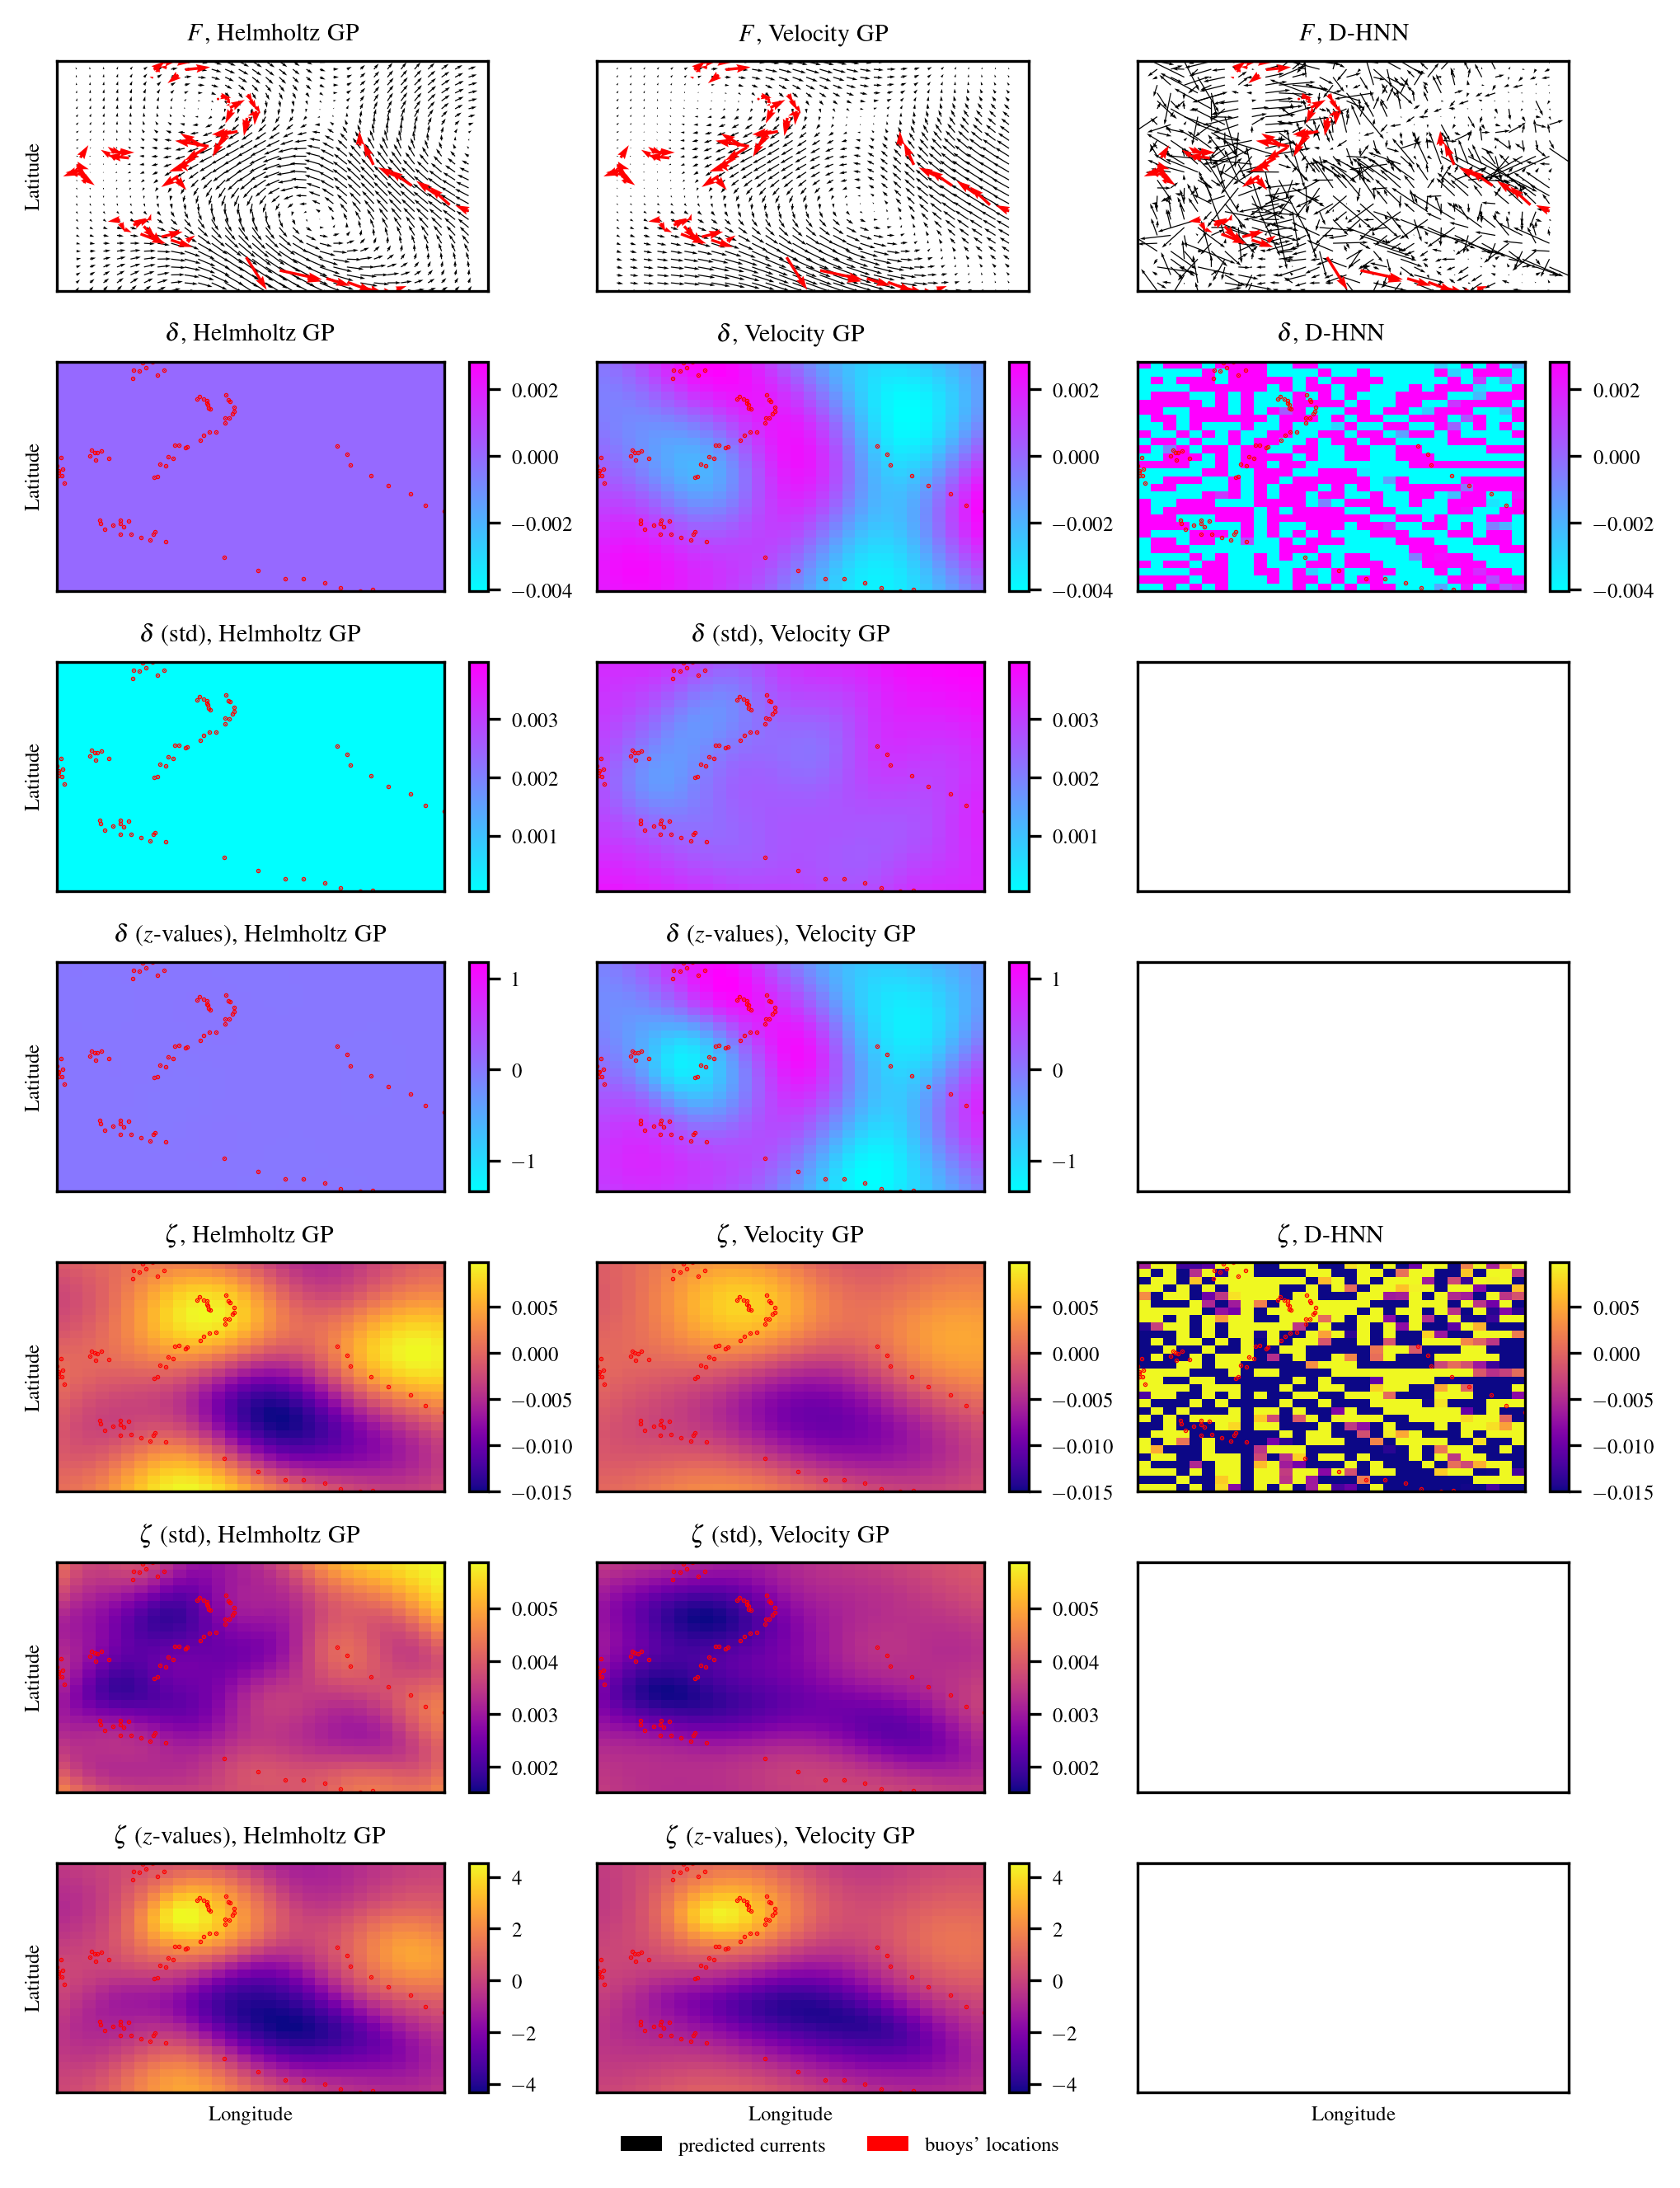

In [37]:
plot_helm.plot_appendix_results_realdata(X_grid, Y_grid, XY_train, UV_train,
                                        opt_post_mean_helm, opt_post_cov_helm, 
                                        opt_post_mean_uv, opt_post_cov_uv, 
                                        div_mean_helm, div_var_helm, 
                                        div_mean_std, div_var_std, 
                                        vort_mean_helm, vort_var_helm, 
                                        vort_mean_std, vort_var_std,
                                        y_hat_test, 
                                        divergence_dhnn, vorticity_dhnn, 
                                        cmap='cool', cmap_vort='plasma', scale=0.02, save_dest = "../plots_arxiv/glad_sparse_appendix")